### Instantiating VGG16 Convolutional base

In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (150, 150, 3))

In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

### Feature Extraction without Data Augumentation

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = "D:\Bunny\Projects\Self\Cats Vs Dogs classification\kagglecatsanddogs_small"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale = 1.0/255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape = (sample_count, 4, 4, 512))
    labels = np.zeros(shape = (sample_count,))
    
    generator = datagen.flow_from_directory(
                    directory,
                    target_size = (150, 150),
                    batch_size = batch_size,
                    class_mode = 'binary')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features[i * batch_size : (i + 1) * batch_size] = conv_base.predict(inputs_batch)
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        
        if i * batch_size >= sample_count:
            break
    
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, valiadation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 2s 2s/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 2s 2s/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 2s 2s/step


In [4]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

### Defining and training Densely Connected Classifier

In [5]:
from keras import models
from keras import layers
from keras.optimizers import RMSprop

model = models.Sequential()
model.add(layers.Dense(256, activation = 'relu', input_shape = (4 * 4 * 512, )))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = RMSprop(learning_rate = 1e-4), metrics = ['accuracy'])

history = model.fit(train_features, train_labels, 
                    epochs = 30, 
                    batch_size = 32, 
                    validation_data = (validation_features, valiadation_labels))

Epoch 1/30
63/63 [==============================] - 5s 54ms/step - loss: 0.4574 - accuracy: 0.7810 - val_loss: 0.3481 - val_accuracy: 0.8330
Epoch 2/30
63/63 [==============================] - 3s 41ms/step - loss: 0.2949 - accuracy: 0.8745 - val_loss: 0.2721 - val_accuracy: 0.8940
Epoch 3/30
63/63 [==============================] - 3s 41ms/step - loss: 0.2516 - accuracy: 0.8985 - val_loss: 0.2801 - val_accuracy: 0.8780
Epoch 4/30
63/63 [==============================] - 3s 41ms/step - loss: 0.2012 - accuracy: 0.9250 - val_loss: 0.3027 - val_accuracy: 0.8640
Epoch 5/30
63/63 [==============================] - 3s 44ms/step - loss: 0.1832 - accuracy: 0.9285 - val_loss: 0.2383 - val_accuracy: 0.9060
Epoch 6/30
63/63 [==============================] - 2s 39ms/step - loss: 0.1606 - accuracy: 0.9405 - val_loss: 0.2402 - val_accuracy: 0.9020
Epoch 7/30
63/63 [==============================] - 2s 39ms/step - loss: 0.1343 - accuracy: 0.9470 - val_loss: 0.2434 - val_accuracy: 0.9060
Epoch 8/30
63

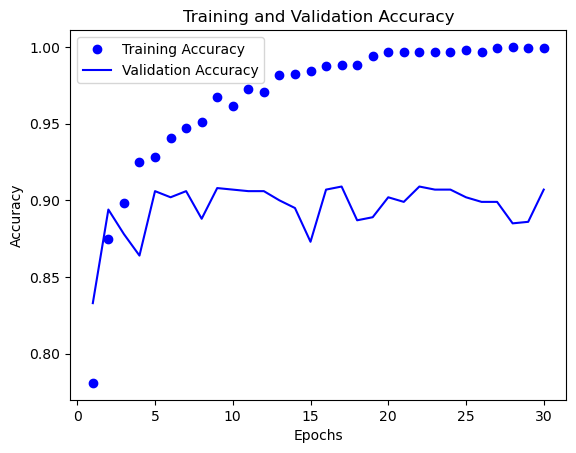

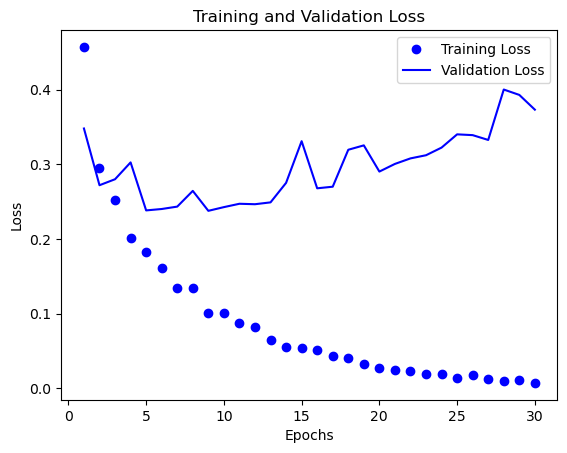

<Figure size 640x480 with 0 Axes>

In [6]:
#### Plotting the results

import matplotlib.pyplot as plt

epochs = range(1, 31)

train_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, validation_acc, 'b', label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

train_loss = history.history['loss']
validation_loss = history.history['val_loss']
plt.plot(epochs, train_loss, 'bo', label = 'Training Loss')
plt.plot(epochs, validation_loss, 'b', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()
plt.clf()

### Data Extraction using Data Augmentation

In [7]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [8]:
conv_base.trainable = False

In [9]:
train_datagen = ImageDataGenerator(
                    rescale = 1.0/255,
                    rotation_range = 40,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    fill_mode = 'nearest')
train_generator = train_datagen.flow_from_directory(
                        train_dir,
                        target_size = (150, 150),
                        batch_size = 20,
                        class_mode = 'binary')

validation_datagen = ImageDataGenerator(rescale = 1.0/255)
validation_generator = validation_datagen.flow_from_directory(
                            validation_dir,
                            target_size = (150, 150),
                            batch_size = 20,
                            class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
model.compile(loss = 'binary_crossentropy', optimizer = RMSprop(learning_rate = 1e-4), metrics = ['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch = 100, 
                    epochs = 30, 
                    validation_data = validation_generator, 
                    validation_steps = 50)

Epoch 1/30
100/100 [==============================] - 300s 3s/step - loss: 0.5199 - accuracy: 0.7380 - val_loss: 0.3737 - val_accuracy: 0.8280
Epoch 2/30
100/100 [==============================] - 295s 3s/step - loss: 0.4176 - accuracy: 0.8010 - val_loss: 0.3217 - val_accuracy: 0.8620
Epoch 3/30
100/100 [==============================] - 255s 3s/step - loss: 0.3799 - accuracy: 0.8220 - val_loss: 0.2611 - val_accuracy: 0.8890
Epoch 4/30
100/100 [==============================] - 254s 3s/step - loss: 0.3643 - accuracy: 0.8435 - val_loss: 0.2573 - val_accuracy: 0.8930
Epoch 5/30
100/100 [==============================] - 260s 3s/step - loss: 0.3406 - accuracy: 0.8510 - val_loss: 0.2516 - val_accuracy: 0.8880
Epoch 6/30
100/100 [==============================] - 257s 3s/step - loss: 0.3279 - accuracy: 0.8515 - val_loss: 0.2543 - val_accuracy: 0.8950
Epoch 7/30
100/100 [==============================] - 257s 3s/step - loss: 0.3268 - accuracy: 0.8590 - val_loss: 0.3708 - val_accuracy: 0.8370

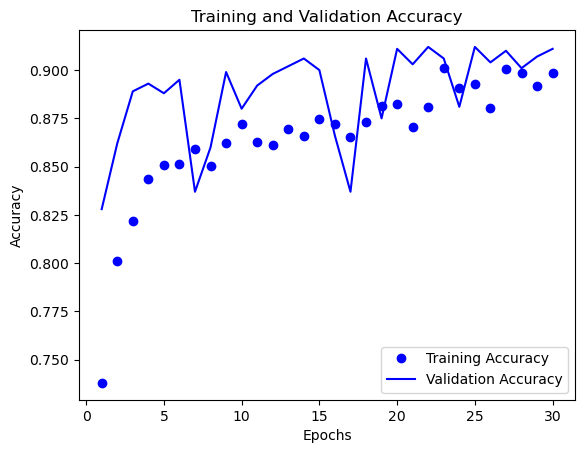

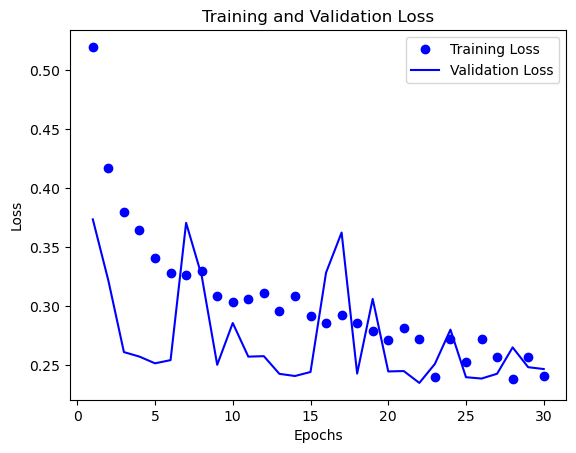

<Figure size 640x480 with 0 Axes>

In [11]:
### Plotting the results

epochs = range(1, 31)

train_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, validation_acc, 'b', label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

train_loss = history.history['loss']
validation_loss = history.history['val_loss']
plt.plot(epochs, train_loss, 'bo', label = 'Training Loss')
plt.plot(epochs, validation_loss, 'b', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()
plt.clf()

### Fine Tuning

In [12]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [13]:
conv_base.trainable = False

for layer in conv_base.layers:
    if layer.name[0:6] == 'block5':
        layer.trainable = True

In [14]:
model.compile(loss = 'binary_crossentropy', optimizer = RMSprop(learning_rate = 1e-4), metrics = ['accuracy'])

history = model.fit(train_generator, 
                    steps_per_epoch = 100, 
                    epochs = 30, 
                    validation_data = validation_generator, 
                    validation_steps = 50)

Epoch 1/30
100/100 [==============================] - 237s 2s/step - loss: 0.2593 - accuracy: 0.8875 - val_loss: 0.2498 - val_accuracy: 0.8950
Epoch 2/30
100/100 [==============================] - 235s 2s/step - loss: 0.2480 - accuracy: 0.8940 - val_loss: 0.2425 - val_accuracy: 0.9100
Epoch 3/30
100/100 [==============================] - 236s 2s/step - loss: 0.2492 - accuracy: 0.8975 - val_loss: 0.2526 - val_accuracy: 0.9050
Epoch 4/30
100/100 [==============================] - 235s 2s/step - loss: 0.2574 - accuracy: 0.8835 - val_loss: 0.2528 - val_accuracy: 0.9010
Epoch 5/30
100/100 [==============================] - 239s 2s/step - loss: 0.2376 - accuracy: 0.8975 - val_loss: 0.2800 - val_accuracy: 0.8910
Epoch 6/30
100/100 [==============================] - 234s 2s/step - loss: 0.2488 - accuracy: 0.8940 - val_loss: 0.2425 - val_accuracy: 0.9090
Epoch 7/30
100/100 [==============================] - 234s 2s/step - loss: 0.2433 - accuracy: 0.9010 - val_loss: 0.2499 - val_accuracy: 0.9030

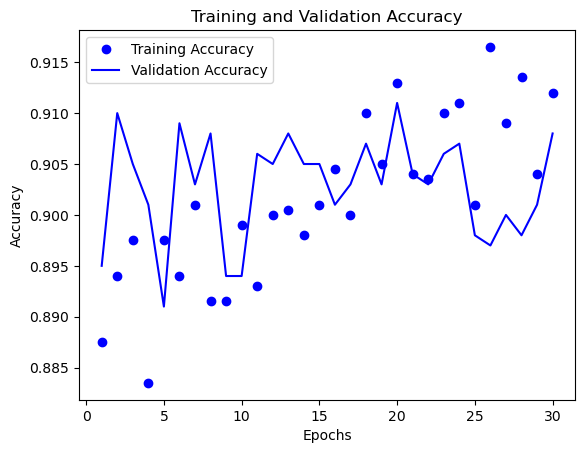

<Figure size 640x480 with 0 Axes>

In [15]:
### Plotting the results

epochs = range(1, 31)

train_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, validation_acc, 'b', label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

train_loss = history.history['loss']
validation_loss = history.history['val_loss']
plt.plot(epochs, train_loss, 'bo', label = 'Training Loss')
plt.plot(epochs, validation_loss, 'b', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.plot()
plt.clf()

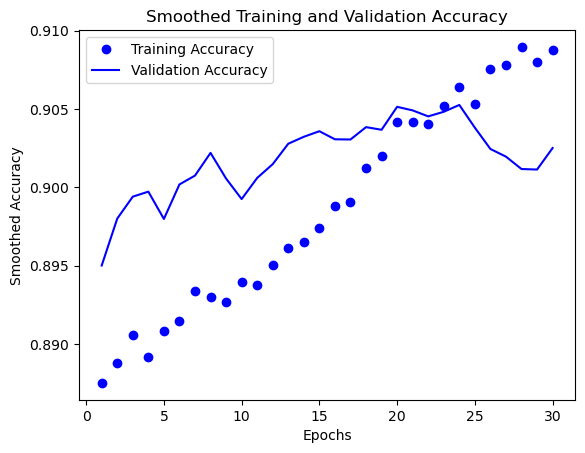

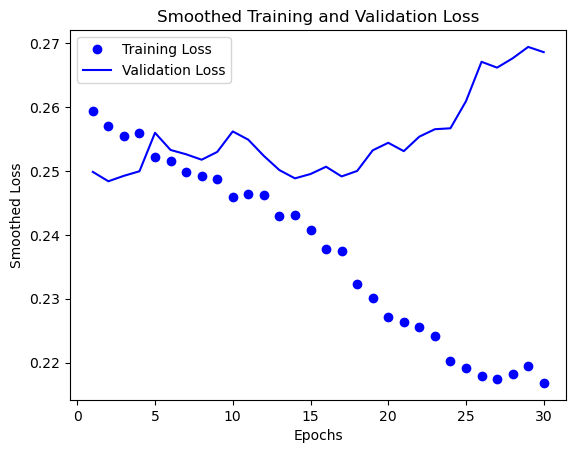

<Figure size 640x480 with 0 Axes>

In [16]:
### Smoothing the points

def smooth_curve(points, factor = 0.8):
    smooth_points = []
    
    for point in points:
        if smooth_points:
            prev = smooth_points[-1]
            smooth_points.append(prev * factor + point * (1 - factor))
        else:
            smooth_points.append(point)
    
    return smooth_points

plt.plot(epochs, smooth_curve(train_acc), 'bo', label = 'Training Accuracy')
plt.plot(epochs, smooth_curve(validation_acc), 'b', label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Smoothed Accuracy')
plt.title('Smoothed Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(train_loss), 'bo', label = 'Training Loss')
plt.plot(epochs, smooth_curve(validation_loss), 'b', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Smoothed Loss')
plt.title('Smoothed Training and Validation Loss')
plt.legend()

plt.show()
plt.clf()

### Evaluating on Test data

In [17]:
test_generator = validation_datagen.flow_from_directory(
                    test_dir, 
                    target_size = (150, 150),
                    batch_size = 20, 
                    class_mode = 'binary')

test_loss, test_accuracy = model.evaluate(test_generator, steps = 50)
print('Test loss :', test_loss)
print('Test accuracy :', test_accuracy)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 79s 2s/step - loss: 0.2484 - accuracy: 0.9100
Test loss : 0.24841724336147308
Test accuracy : 0.9100000262260437
